In [74]:
import os
import numpy as np
import pandas as pd
import torch
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.spatial import distance_matrix
from sklearn.metrics import roc_auc_score, roc_curve

from dataloading import get_dataloader_test
from models_binary import CNN_binary

In [8]:
batch_size = 256
model_path = "./ckpts/binary.ckpt"

In [7]:
dataset_folder = os.path.join('..', 'dataset', 'dataset1')
# Read the training set
test_loader, num_classes = get_dataloader_test(dataset_folder, batch_size)

print("Number of classes: ", int(num_classes))
print("Num samples:", len(test_loader))

Number of classes:  118
Num samples: 15


In [11]:
model = CNN_binary(num_classes)
model.load_state_dict(torch.load(model_path))
model.eval()
extractor = model.net

C:\Users\giaco\AppData\Local\Temp\ipykernel_5724\3259300985.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [63]:
embeddings, labels = [], []

with torch.no_grad():
    for X, y in test_loader:
        e = extractor(X).reshape(X.size(0), -1)

        embeddings.append(e.numpy())
        labels.append(y.numpy())

embeddings = np.vstack(embeddings)
labels = np.hstack(labels)

# sort by class
indices = np.argsort(labels)
embeddings = embeddings[indices, :]
labels = labels[indices]

embeddings.shape, labels.shape

((3740, 2048), (3740,))

In [64]:
N = len(labels)
mask_matrix = np.ones((N, N), dtype=np.int16)
class_matrix = np.ones((N, N), dtype=np.int16)

for i in range(N):
    for j in range(N):
        if labels[i] == labels[j]:
            mask_matrix[i, j] = 0
            class_matrix[i, j] = labels[i]
        else:
            class_matrix[i, j] = -1

mask_matrix.shape, class_matrix.shape

(3740, 3740)

In [65]:
# 4mins for 4000 vectors
dist_matrix = distance_matrix(embeddings, embeddings, p=2)
dist_matrix.shape

(3740, 3740)

<Axes: >

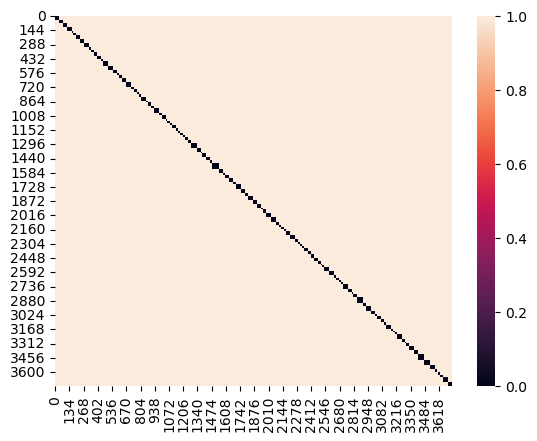

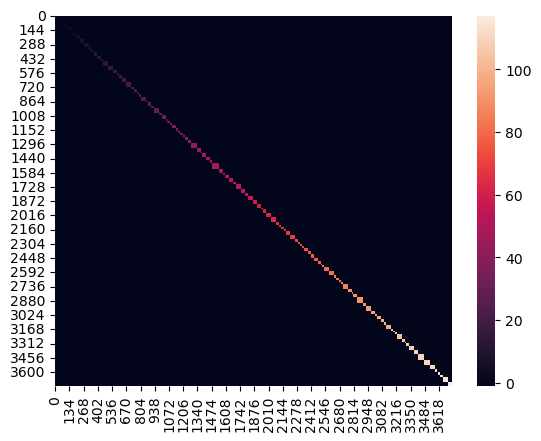

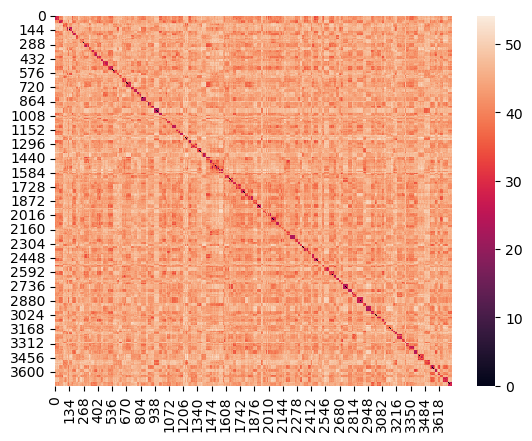

In [66]:
plt.figure()
sns.heatmap(mask_matrix)
plt.figure()
sns.heatmap(class_matrix)
plt.figure()
sns.heatmap(dist_matrix)

Text(0.5, 0, 'Distance')

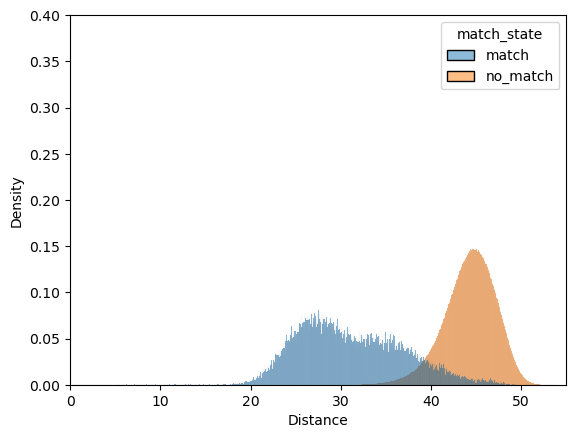

In [69]:
matching = dist_matrix[mask_matrix == 0].flatten()
not_matching = dist_matrix[mask_matrix == 1].flatten()
df_1 = pd.DataFrame({"distance": matching, "match_state": "match"})
df_2 = pd.DataFrame({"distance": not_matching, "match_state": "no_match"})
df = pd.concat((df_1, df_2))

sns.histplot(df, x="distance", hue="match_state", stat="density", common_norm=False)
plt.ylim((0, 0.4))
plt.xlim((0, 55))
plt.xlabel("Distance")

In [76]:
y_true = mask_matrix.flatten()
y_score = dist_matrix.flatten()

fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc_score = roc_auc_score(y_true, y_score)

len(fpr)

45943

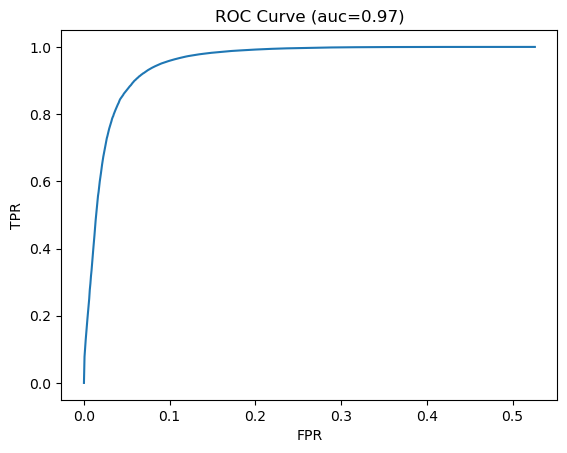

In [82]:
subsample = round(len(fpr) / 500) # render only about 500 curve points
sns.lineplot(x=fpr[::subsample], y=tpr[::subsample])
plt.title(f"ROC Curve (auc={auc_score:.2f})")
plt.xlabel("FPR")
plt.ylabel("TPR");